# Linear Regression to predict cholesterol level

/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Script/Nguyen_data_processor.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)


Raw data correlation with 'chol':
chol        1.000000
thalch      0.236121
trestbps    0.092853
ca          0.051606
oldpeak     0.047734
age        -0.086234
num        -0.231547
Name: chol, dtype: float64

Cleaned data correlation with 'chol':
chol        1.000000
age         0.074192
trestbps    0.071768
num         0.058104
oldpeak     0.040437
thalch     -0.039005
Name: chol, dtype: float64


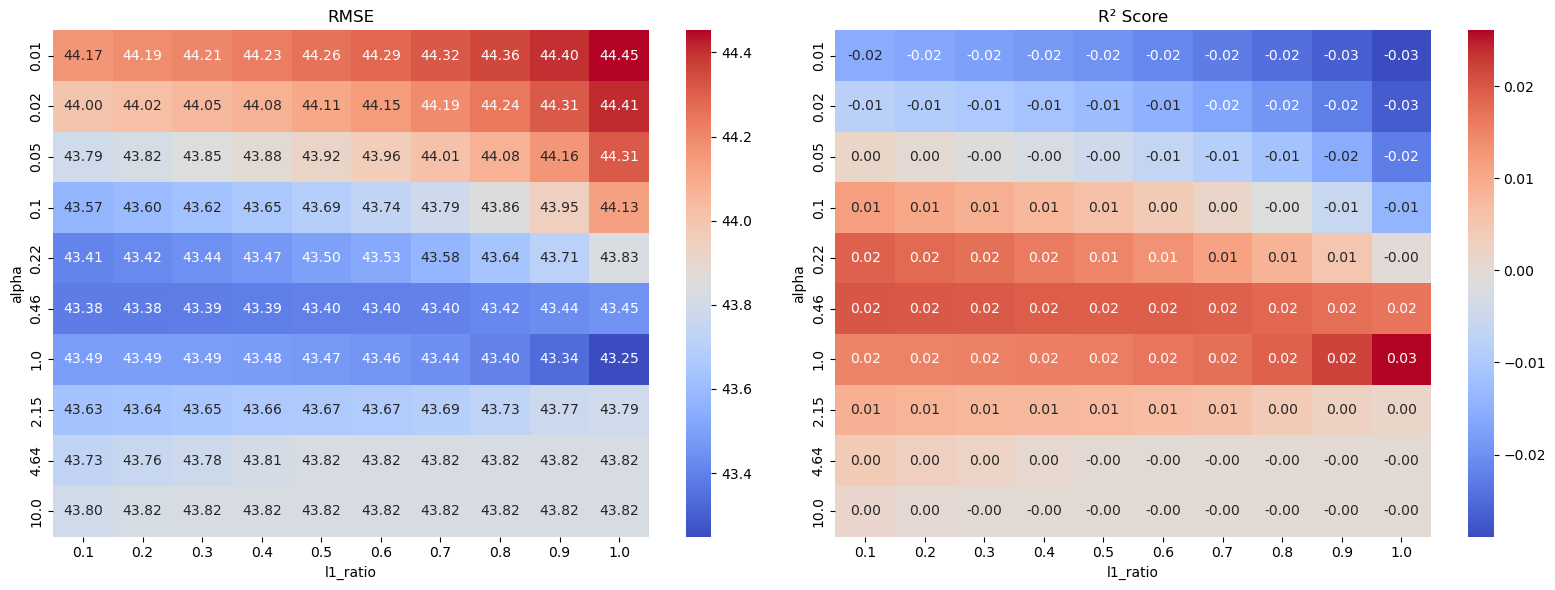

Best alpha and l1_ratio for minimum RMSE: 1.0, 1.0
Best alpha and l1_ratio for maximum R2: 1.0, 1.0


In [123]:
# ======================= Importing packages ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import Nguyen_data_processor as dp  # Custom preprocessing module


# ====================== 1. Load & Clean Data ============================
# Load raw dataset
data = pd.read_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/heart_disease_uci.csv')

# Create a copy for cleaning
clean_data = data.copy()

# Convert the weird values in cholesterol columns (is 0) to NaN for imputing
clean_data.loc[clean_data['chol'] == 0, 'chol'] = np.nan

# Apply data cleaning functions
clean_data = dp.remove_missing_columns(clean_data)
clean_data = dp.impute_missing_values(clean_data)
clean_data = dp.remove_duplicates(clean_data)
clean_data = dp.remove_redundant_features(clean_data)
clean_data = dp.impute_outlier(clean_data, method='mean', threshold=2.5)

# Save cleaned dataset
clean_data.to_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/cleaned_heart_disease_uci.csv', index=False)


# ========================= 2. Explore Correlation ============================
# Use .corr() to check for possible correlation before and after cleaning. 
# This would give context to model evaluation using RMSE and R2
print("Raw data correlation with 'chol':")
print(data.corr(numeric_only=True)['chol'].sort_values(ascending=False))

print("\nCleaned data correlation with 'chol':")
print(clean_data.corr(numeric_only=True)['chol'].sort_values(ascending=False))


# ======================== 3. Prepare Modeling Data ============================
# Drop any rows with NA values
reg_data = clean_data.copy()
reg_data.dropna(inplace = True)

# Split data into features and target
target = reg_data['chol']
features = reg_data.drop(columns = ['chol'])

# Normalize feature data
features = dp.normalize_data(features, method = 'minmax')

# if the column is not numeric, encode it (one-hot)
cat_cols = features.select_dtypes(include='object').columns
features = pd.get_dummies(features, columns = cat_cols, prefix = cat_cols)

# Splitting data set for training and testing
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = 42)


# ============================ 4. Hyperparameter Grid Search ============================
# Make a list of values for alpha and l1_ratio
alphas = np.logspace(-2, 1, 10)
l1_ratios = np.linspace(0.1, 1.0, 10)

# Create a 2D arrays to store subsequent RMSE and R2 values in, 
# with respect to each combination of alpha and l1-ratio
rmse_values_array = np.zeros((len(alphas), len(l1_ratios)))
r2_values_array = np.zeros((len(alphas), len(l1_ratios)))

# Create and fit the model using those 100 combinations of alphas and l1_ratio
for i, alpha_value in enumerate(alphas):
    for j, l1_ratio_value in enumerate(l1_ratios):

        # Fitting ElasticNet model
        reg_model = ElasticNet(alpha=alpha_value, l1_ratio=l1_ratio_value)
        reg_model.fit(x_train, y_train)

        # Predict value and assess model
        y_predict = reg_model.predict(x_test)
        rmse_values_array[i,j] = np.sqrt(mean_squared_error(y_test, y_predict))
        r2_values_array[i,j] = r2_score(y_test, y_predict)


# ============================== 5. Visualize Results ================================
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# RMSE heatmap
sns.heatmap(rmse_values_array, annot=True, fmt=".2f",
            xticklabels=np.round(l1_ratios, 2),
            yticklabels=np.round(alphas, 2),
            cmap="coolwarm", ax=axs[0])
axs[0].set_title("RMSE")
axs[0].set_xlabel("l1_ratio")
axs[0].set_ylabel("alpha")

# R2 heatmap
sns.heatmap(r2_values_array, annot=True, fmt=".2f",
            xticklabels=np.round(l1_ratios, 2),
            yticklabels=np.round(alphas, 2),
            cmap="coolwarm", ax=axs[1])
axs[1].set_title("R² Score")
axs[1].set_xlabel("l1_ratio")
axs[1].set_ylabel("alpha")

plt.tight_layout()
plt.show()


# ============================= 6. Find best config =====================================
# Find the indices of the cell with the minimum RMSE
# Use np.argmin() to find the indices of the minimum value in the 2D array, specifying the shape of the array
# First, it flattens the array into 1D dimension:
#       [1,2,3]
#       [4,5,6]     => [1,2,3,4,5,6,7,8,9]
#       [7,8,9]
# Then it finds the minimum value and return the index in the flattened array. In this case, it would be index 0 (value 1)
# It also returns the shape of the original array.
# We then use np.unravel_index() to convert the index to match the original 2D array, returning a tuple of the input flattened index.
#       [1,2,3]
#       [4,5,6]     => [1,2,3,4,5,6,7,8,9]
#       [7,8,9]     =>  0 = [0,0]
min_rmse_idx = np.unravel_index(np.argmin(rmse_values_array), rmse_values_array.shape)
# After getting the 2D index for best config, we can extract the value of each axis (alpha and l1_ratio)
alpha_min_rmse = alphas[min_rmse_idx[0]]
l1_ratio_min_rmse = l1_ratios[min_rmse_idx[1]]

# Find the indices of the cell with the maximum R2
max_r2_idx = np.unravel_index(np.argmax(r2_values_array), r2_values_array.shape)
alpha_max_r2 = alphas[max_r2_idx[0]]
l1_ratio_max_r2 = l1_ratios[max_r2_idx[1]]

# Print out best config:
print(f"Best alpha and l1_ratio for minimum RMSE: {alpha_min_rmse}, {l1_ratio_min_rmse}")
print(f"Best alpha and l1_ratio for maximum R2: {alpha_max_r2}, {l1_ratio_max_r2}")


### Best configuration is alpha = 1.0 and l1_ratio = 1.
- Data contains lots of noise or irrelevant data => Model favors L1 for feature selection.
- The features available do not strongly predict cholesterol level => weak correlation between features and target (check corr() outputs).

### Low R2 but high RMSE
- Maximum R2 is only 0.03 (with standard scaler) and 0.02 (with min max scaler)
    - Model explains only 2–3% of the variance in cholesterol level => same as a mean prediction. 
    => Features used are not informative for predicting cholesterol.
- Minimum RMSE is ~ 43, which is terrible for cholesterol level since it ranges between 100-300.
    =>  Low precision in prediction.

### For ElasticNet() linear regression, performance of minmax scaling and standard scaling are similar.
- Min-max scaling helps bound data sets, but is sensitive to outliers as it can compress the rest of the data, dampening the influence of important features.
- Standard scaler works better for data with outliers as it converts data based on z-score.
    => Data is bounded similarly across features, and preventing outliers from compressing the rest of the data.
    - Helpful for regularization models such as ElasticNet() as the model penalizes based on coefficients.
        => Regularization penalizes coefficients fairly.
=> The scaling technique is not the problem. 
=> This is likely due to data quality.

AUC-ROC:                0.9140807474140807
Precision-Recall AUC:   0.9169683138976529
Accuracy:               0.864516129032258
F1 score:               0.8711656441717791


/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Script/Nguyen_data_processor.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)


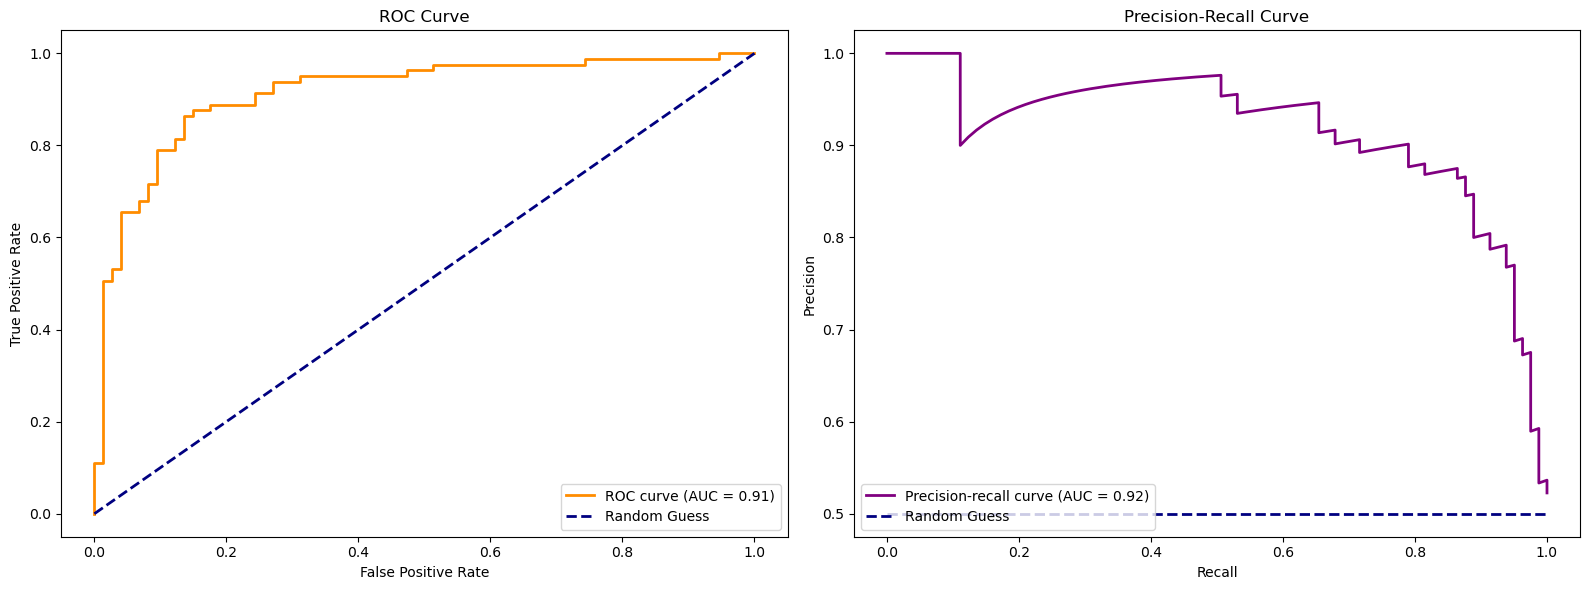

In [131]:
# ======================= Importing packages ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

# Setting the prediction threshold for classification (put it here so it's easier to change)
predict_threshold = 0.5


# ====================== 1. Load & Clean Data ============================
# Load raw dataset
data = pd.read_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/heart_disease_uci.csv')

# Create a copy for cleaning
clean_data = data.copy()

# Convert the weird values in cholesterol columns (is 0) to NaN for imputing
clean_data.loc[clean_data['chol'] == 0, 'chol'] = np.nan

# Apply data cleaning functions
clean_data = dp.remove_missing_columns(clean_data)
clean_data = dp.impute_missing_values(clean_data)
clean_data = dp.remove_duplicates(clean_data)
clean_data = dp.remove_redundant_features(clean_data)
clean_data = dp.impute_outlier(clean_data, method='mean', threshold=2.5)

# Save cleaned dataset
clean_data.to_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/cleaned_heart_disease_uci.csv', index=False)


# ======================== 2. Prepare Modeling Data ============================
# Drop any rows with NA values
reg_data = clean_data.copy()

# The column "num" has values as [0,1,2,3,4] indicating severity of heart disease
#       0: No significant heart disease
#       1, 2, 3, 4: Presence of heart disease with increasing severity
# We want to check for presence of heart disease, so [1, 2, 3, 4] will all be converted to 1 (presence) 
# reg_data.loc[~(reg_data['num'].isin([0,1])), 'num'] =  float('NaN')
reg_data.dropna(inplace = True)
reg_data.loc[(reg_data['num'].isin([1,2,3,4])), 'num'] = 1

# Split data into features and target
target = reg_data['num'].astype('category')
features = reg_data.drop(columns = ['num'])

# Normalize feature data
features = dp.normalize_data(features, method = 'standard')

# if the column is not numeric, encode it (one-hot)
cat_cols = features.select_dtypes(include='object').columns
features = pd.get_dummies(features, columns = cat_cols, prefix = cat_cols)

# Splitting data set for training and testing
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = 42)


# ====================== 3. Logistic Regression Model ==========================
# Make logistic regression model
logistic_model = LogisticRegression(penalty = 'l2',
                                    solver = 'liblinear',
                                    C = 0.03, random_state=42)  # C (inverse regularization) controls the strength of regularization
                                                                # Larger C => less regularization => keep the complexity of the model 
                                                                # Smaller C => stronger penalty => encourages simpler model and prevent overfitting
                                                                # but may lead to underfitting
logistic_model.fit(x_train, y_train)

# Predict the propability of each classification
y_predict = logistic_model.predict_proba(x_test)[:, 1] 

# Compute ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_predict)
average_precision = average_precision_score(y_test, y_predict)

# Convert probabilities to binary labels using threshold
y_predict_binary = (y_predict >= predict_threshold).astype(int)
y_test_binary = y_test.astype(int)

# Accuracy and F1
accuracy_log = accuracy_score(y_test_binary, y_predict_binary)
f1 = f1_score(y_test_binary, y_predict_binary)

# Print results
print(f"AUC-ROC:                {roc_auc}")
print(f"Precision-Recall AUC:   {average_precision}")
print(f"Accuracy:               {accuracy_log}")
print(f"F1 score:               {f1}")


# ============================= 4. Visualization ===============================
fig, axs = plt.subplots(1,2,figsize=(16,6))

# Make ROC plot
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')

# Make precision-recall plot
axs[1].plot(recall, precision, color='purple', lw=2, label='Precision-recall curve (AUC = %0.2f)' % average_precision)
axs[1].plot([0, 1], [0.5, 0.5], color='navy', lw=2, linestyle='--', label='Random Guess')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')

# Print plot
plt.tight_layout()
plt.show()

### Standard scaler instead of minmax scaler:
- Standard scaler is slightly better than minmax, indicating potential outliers.

### Probability threshold of 0.5:
- 0.5 is optimal.

### Penalty and solver:
- L1 (feature selection) reduced model performance but not noticeable.
- L2 (reducing coefficient) worked a little better than not using any regularization. No difference between solver choices.

### C = 0.03:
- C is the inverse of regularization. 
    - Smaller C => stronger regularization => simplifying model.
    - Larger C => weaker regularization => keeping model's complexity.
=> Optimal C of 0.03 means the model requires more regularization, indicating noise and/or irrelevant features.

### Changing hyperparameter doesn't affect the model performance much.


### Overall, the most optimal condition seemed to be:
    - Penalty: 'l2'
    - Solver: 'liblinear' (no difference between different metrics)
    - C = 0.03
- However, each evaluation metric changed the model performance by 0.01-0.03.

AUC-ROC:                0.9049049049049049
Precision-Recall AUC:   0.8978846594740317
Accuracy:               0.8258064516129032
F1 score:               0.8439306358381503


/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Script/Nguyen_data_processor.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)


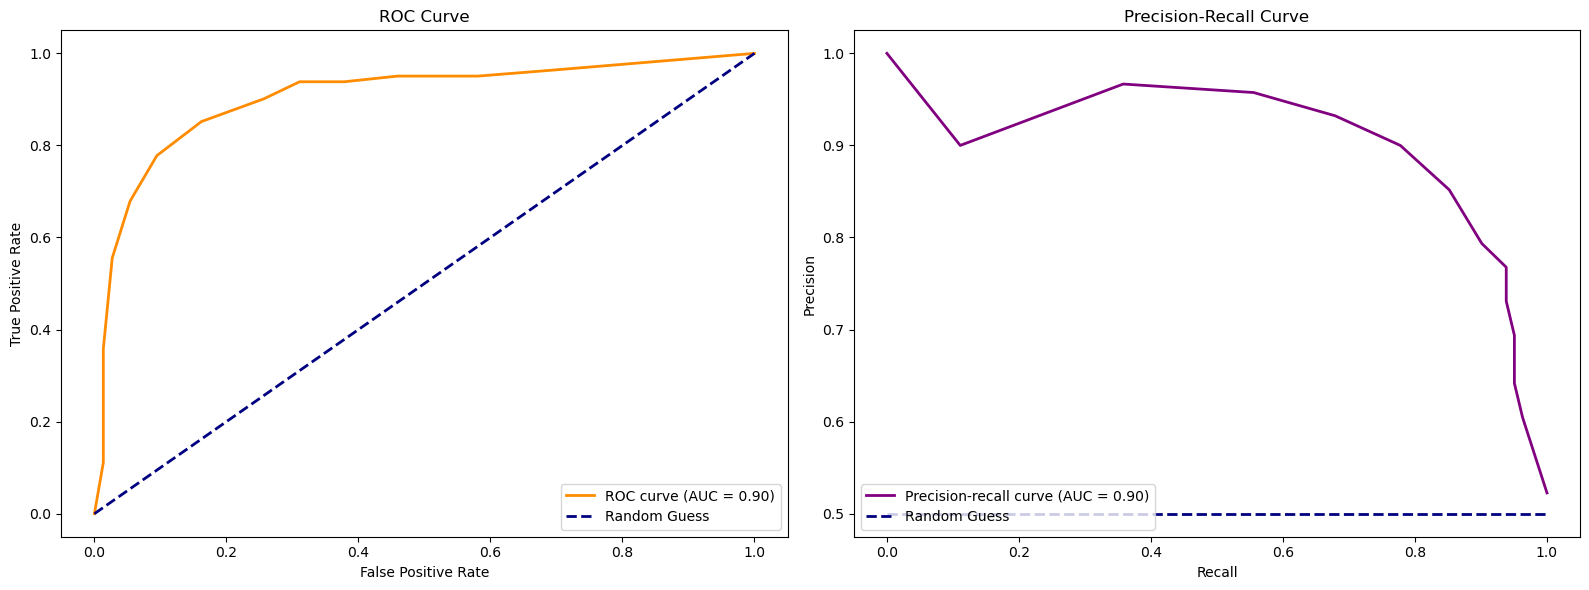

In [129]:
# ======================= Importing packages ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score

predict_threshold = 0.5


# ====================== 1. Load & Clean Data ============================
# Load raw dataset
data = pd.read_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/heart_disease_uci.csv')

# Create a copy for cleaning
clean_data = data.copy()

# Convert the weird values in cholesterol columns (is 0) to NaN for imputing
clean_data.loc[clean_data['chol'] == 0, 'chol'] = np.nan

# Apply data cleaning functions
clean_data = dp.remove_missing_columns(clean_data)
clean_data = dp.impute_missing_values(clean_data)
clean_data = dp.remove_duplicates(clean_data)
clean_data = dp.remove_redundant_features(clean_data)
clean_data = dp.impute_outlier(clean_data, method='mean', threshold=2.5)

# Save cleaned dataset
clean_data.to_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/cleaned_heart_disease_uci.csv', index=False)


# ======================== 2. Prepare Modeling Data ============================
# Drop any rows with NA values
reg_data = clean_data.copy()

# The column "num" has values as [0,1,2,3,4] indicating severity of heart disease
#       0: No significant heart disease
#       1, 2, 3, 4: Presence of heart disease with increasing severity
# We want to check for presence of heart disease, so [1, 2, 3, 4] will all be converted to 1 (presence) 
# reg_data.loc[~(reg_data['num'].isin([0,1])), 'num'] =  float('NaN')
reg_data.dropna(inplace = True)
reg_data.loc[(reg_data['num'].isin([1,2,3,4])), 'num'] = 1

# Split data into features and target
target = reg_data['num'].astype('category')
features = reg_data.drop(columns = ['num'])

# Normalize feature data
features = dp.normalize_data(features, method = 'standard')

# if the column is not numeric, encode it (one-hot)
cat_cols = features.select_dtypes(include='object').columns
features = pd.get_dummies(features, columns = cat_cols, prefix = cat_cols)

# Splitting data set for training and testing
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = 42)


# ====================== 3. k-Nearest Neighbour Model ==========================
# Make kNN model
knn_model = KNeighborsClassifier(n_neighbors=12,metric='manhattan')
knn_model.fit(x_train, y_train)

# Predict the propability of each classification
y_predict = knn_model.predict_proba(x_test)[:, 1] 

# Compute ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_predict)
roc_auc = auc(fpr, tpr)

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_predict)
average_precision = average_precision_score(y_test, y_predict)

# Convert probabilities to binary labels using threshold
y_predict_binary = (y_predict >= predict_threshold).astype(int)
y_test_binary = y_test.astype(int)

# Accuracy and F1
accuracy_log = accuracy_score(y_test_binary, y_predict_binary)
f1 = f1_score(y_test_binary, y_predict_binary)

# Print results
print(f"AUC-ROC:                {roc_auc}")
print(f"Precision-Recall AUC:   {average_precision}")
print(f"Accuracy:               {accuracy_log}")
print(f"F1 score:               {f1}")


# =============================== 4. Visualization ==================================
fig, axs = plt.subplots(1,2,figsize=(16,6))

# Make ROC plot
axs[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve')
axs[0].legend(loc='lower right')

# Make precision-recall plot
axs[1].plot(recall, precision, color='purple', lw=2, label='Precision-recall curve (AUC = %0.2f)' % average_precision)
axs[1].plot([0, 1], [0.5, 0.5], color='navy', lw=2, linestyle='--', label='Random Guess')
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc='lower left')

# Print plot
plt.tight_layout()
plt.show()

### Distance metrics = 'manhattan' 
No significant differences between distance matrix but 'manhattan' seemed to work best.

### Propability threshold of 0.5 seems to be most optimal

### Standard scaling works a bit better than min max

### k number:
n_neighbour: 12
    - AUC-ROC:                0.9049049049049049
    - Precision-Recall AUC:   0.8978846594740317
    - Accuracy:               0.8258064516129032
    - F1 score:               0.8439306358381503

n_neighbour: 8
    - AUC-ROC:                0.8738738738738738
    - Precision-Recall AUC:   0.8570205365900347
    - Accuracy:               0.8387096774193549
    - F1 score:               0.8554913294797688

-  k = 12 has highest ROC and Precision-Recall AUC.
-  k = 8 has highest accuracy and F1 score.

=> Larger K reduces overfitting but may oversimplifies the model. Smaller K captures local pattern but may overfits.

